# Distributed random-search hyper-parameter optimization of the Keras RPV classifier

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os

# External imports
import ipyparallel as ipp
import numpy as np
import keras
import matplotlib.pyplot as plt

# Local imports
from rpv import load_file

/global/cscratch1/sd/sfarrell/conda/isc-ihpc/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Connect to cluster

In [2]:
%%bash
squeue -u sfarrell

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13283811      resv       sh sfarrell  R    1:02:12    112 nid0[1273-1279,1281-1283,1285-1292,1294-1315,1317-1338,1340,1342-1343,1345-1347,1352-1355,1360-1363,1365-1384,1387-1388,1390-1403]


In [3]:
# Cluster ID taken from job ID above
job_id = 13283811
cluster_id = 'cori_{}'.format(job_id)

# Use default profile
c = ipp.Client(timeout=60, cluster_id=cluster_id)
print('Worker IDs:', c.ids)

Worker IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]


## Configure the hyper-parameter search tasks

In [8]:
# Data config
n_train = 64000 #412416
n_valid = 32000 #137471
n_test = 32000 #137471
input_dir = '/global/cscratch1/sd/sfarrell/atlas-rpv-images'

In [13]:
# Temporarily making things reproducible for development
np.random.seed(0)

# Define the hyper-parameter search points
n_hpo_trials = 336
h1 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
h2 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
h3 = np.random.choice([8, 16, 32, 64, 128], size=n_hpo_trials)
conv_sizes = np.stack([h1, h2, h3], axis=1)
fc_sizes = np.random.choice([32, 64, 128, 256], size=(n_hpo_trials, 1))
lr = np.random.choice([0.0001, 0.001, 0.01], size=n_hpo_trials)
dropout = np.random.rand(n_hpo_trials)
optimizer = np.random.choice(['Adadelta', 'Adam', 'Nadam'], size=n_hpo_trials)

# Training config
batch_size = 64
n_epochs = 16
checkpoint_dir = os.path.join(os.environ['SCRATCH'],
                              'cori-interactive-dl/rpv_hpo_%i' % job_id)
os.makedirs(checkpoint_dir, exist_ok=True)

## Run the hyper-parameter search

In [14]:
def build_and_train(input_dir, n_train, n_valid,
                    conv_sizes, fc_sizes, dropout, optimizer, lr,
                    batch_size, n_epochs, checkpoint_file=None, verbose=2):
    """Run training for one set of hyper-parameters"""
    import os
    import keras
    from rpv import build_model, train_model, load_file
    from mlextras import configure_session
    print('Hyperparameters: conv %s fc %s dropout %.3f opt %s, lr %.4f' %
          (conv_sizes, fc_sizes, dropout, optimizer, lr))
    # Load the dataset
    train_input, train_labels, train_weights = load_file(os.path.join(input_dir, 'train.h5'), n_train)
    valid_input, valid_labels, valid_weights = load_file(os.path.join(input_dir, 'val.h5'), n_valid)
    print('train shape:', train_input.shape, 'Mean label:', train_labels.mean())
    print('valid shape:', valid_input.shape, 'Mean label:', valid_labels.mean())
    # Thread settings
    keras.backend.set_session(configure_session())
    # Build the model
    model = build_model(train_input.shape[1:],
                        conv_sizes=conv_sizes, fc_sizes=fc_sizes,
                        dropout=dropout, optimizer=optimizer, lr=lr)
    # Train the model
    history = train_model(model, train_input=train_input, train_labels=train_labels,
                          valid_input=valid_input, valid_labels=valid_labels,
                          batch_size=batch_size, n_epochs=n_epochs,
                          checkpoint_file=checkpoint_file, verbose=verbose)
    return history.history

In [15]:
# Load-balanced view
lv = c.load_balanced_view()

# Loop over hyper-parameter sets
results = []
for ihp in range(n_hpo_trials):
    print('Hyperparameter trial %i conv %s fc %s dropout %.4f opt %s, lr %.4f' %
          (ihp, conv_sizes[ihp], fc_sizes[ihp], dropout[ihp], optimizer[ihp], lr[ihp]))
    checkpoint_file = os.path.join(checkpoint_dir, 'model_%i.h5' % ihp)
    result = lv.apply(build_and_train,
                      input_dir, n_train, n_valid,
                      conv_sizes=conv_sizes[ihp], fc_sizes=fc_sizes[ihp],
                      dropout=dropout[ihp], optimizer=optimizer[ihp], lr=lr[ihp],
                      batch_size=batch_size, n_epochs=n_epochs,
                      checkpoint_file=checkpoint_file)
    results.append(result)

Hyperparameter trial 0 conv [ 64  16 128] fc [128] dropout 0.3234 opt Nadam, lr 0.0100
Hyperparameter trial 1 conv [ 4  8 64] fc [64] dropout 0.6747 opt Adadelta, lr 0.0010
Hyperparameter trial 2 conv [32 16  8] fc [32] dropout 0.6732 opt Nadam, lr 0.0010
Hyperparameter trial 3 conv [ 32   8 128] fc [256] dropout 0.8024 opt Adadelta, lr 0.0001
Hyperparameter trial 4 conv [32 64 16] fc [256] dropout 0.0001 opt Adam, lr 0.0100
Hyperparameter trial 5 conv [ 8  8 32] fc [32] dropout 0.6472 opt Adadelta, lr 0.0010
Hyperparameter trial 6 conv [32  4 16] fc [64] dropout 0.6729 opt Adam, lr 0.0010
Hyperparameter trial 7 conv [ 16   4 128] fc [256] dropout 0.5774 opt Nadam, lr 0.0001
Hyperparameter trial 8 conv [64  4 16] fc [32] dropout 0.7774 opt Adadelta, lr 0.0001
Hyperparameter trial 9 conv [  4   4 128] fc [32] dropout 0.1435 opt Adam, lr 0.0100
Hyperparameter trial 10 conv [ 4  4 16] fc [64] dropout 0.3013 opt Nadam, lr 0.0010
Hyperparameter trial 11 conv [64  8 32] fc [32] dropout 0.755

Hyperparameter trial 183 conv [16 16 32] fc [32] dropout 0.8022 opt Nadam, lr 0.0010
Hyperparameter trial 184 conv [32 32 16] fc [64] dropout 0.7435 opt Adam, lr 0.0100
Hyperparameter trial 185 conv [16  4 64] fc [64] dropout 0.8663 opt Nadam, lr 0.0010
Hyperparameter trial 186 conv [64  4  8] fc [256] dropout 0.9275 opt Adadelta, lr 0.0010
Hyperparameter trial 187 conv [32  8 64] fc [256] dropout 0.0136 opt Nadam, lr 0.0001
Hyperparameter trial 188 conv [32  4 16] fc [64] dropout 0.4804 opt Nadam, lr 0.0001
Hyperparameter trial 189 conv [ 4  4 16] fc [32] dropout 0.9172 opt Adadelta, lr 0.0001
Hyperparameter trial 190 conv [32 16 16] fc [256] dropout 0.1699 opt Nadam, lr 0.0100
Hyperparameter trial 191 conv [ 4 32 16] fc [64] dropout 0.0392 opt Adam, lr 0.0100
Hyperparameter trial 192 conv [64 64  8] fc [128] dropout 0.4301 opt Adam, lr 0.0100
Hyperparameter trial 193 conv [16 32 64] fc [64] dropout 0.4313 opt Nadam, lr 0.0100
Hyperparameter trial 194 conv [32 32  8] fc [256] dropout 

In [48]:
print('Tasks completed: %i / %i' % (np.sum([ar.ready() for ar in results]), len(results)))

Tasks completed: 256 / 336


In [43]:
# Print standard out for one of the runs
ar = results[0]
print(ar.stdout)

Hyperparameters: conv [ 64  16 128] fc [128] dropout 0.323 opt Nadam, lr 0.0100
train shape: (64000, 64, 64, 1) Mean label: 0.428734375
valid shape: (32000, 64, 64, 1) Mean label: 0.4258125
Train on 64000 samples, validate on 32000 samples
Epoch 1/16
 - 108s - loss: 0.2698 - acc: 0.8946 - val_loss: 0.2487 - val_acc: 0.9015
Epoch 2/16
 - 104s - loss: 0.2445 - acc: 0.9021 - val_loss: 0.2364 - val_acc: 0.9050
Epoch 3/16
 - 108s - loss: 0.2419 - acc: 0.9030 - val_loss: 0.2248 - val_acc: 0.9096
Epoch 4/16
 - 103s - loss: 0.2334 - acc: 0.9084 - val_loss: 0.2212 - val_acc: 0.9136
Epoch 5/16
 - 104s - loss: 0.2182 - acc: 0.9128 - val_loss: 0.2002 - val_acc: 0.9206
Epoch 6/16
 - 105s - loss: 0.2140 - acc: 0.9155 - val_loss: 0.1959 - val_acc: 0.9213
Epoch 7/16
 - 107s - loss: 0.2087 - acc: 0.9185 - val_loss: 0.2052 - val_acc: 0.9216
Epoch 8/16
 - 106s - loss: 0.2022 - acc: 0.9211 - val_loss: 0.1837 - val_acc: 0.9287
Epoch 9/16
 - 105s - loss: 0.2007 - acc: 0.9218 - val_loss: 0.1882 - val_acc: 0.

In [49]:
# Pull the results from all of the runs that have finished
histories = [ar.get() if ar.ready() else None for ar in results]
# histories = [ar.get() for ar in results]

In [84]:
dt = (ar.completed - ar.started)

In [88]:
dt.seconds

1797

In [90]:
dt.total_seconds()

1797.551829

In [92]:
done_results = [ar for ar in results if ar.ready()]

In [93]:
times = [(ar.completed-ar.started).total_seconds()/60. for ar in done_results]

In [95]:
%matplotlib notebook

<IPython.core.display.Javascript object>


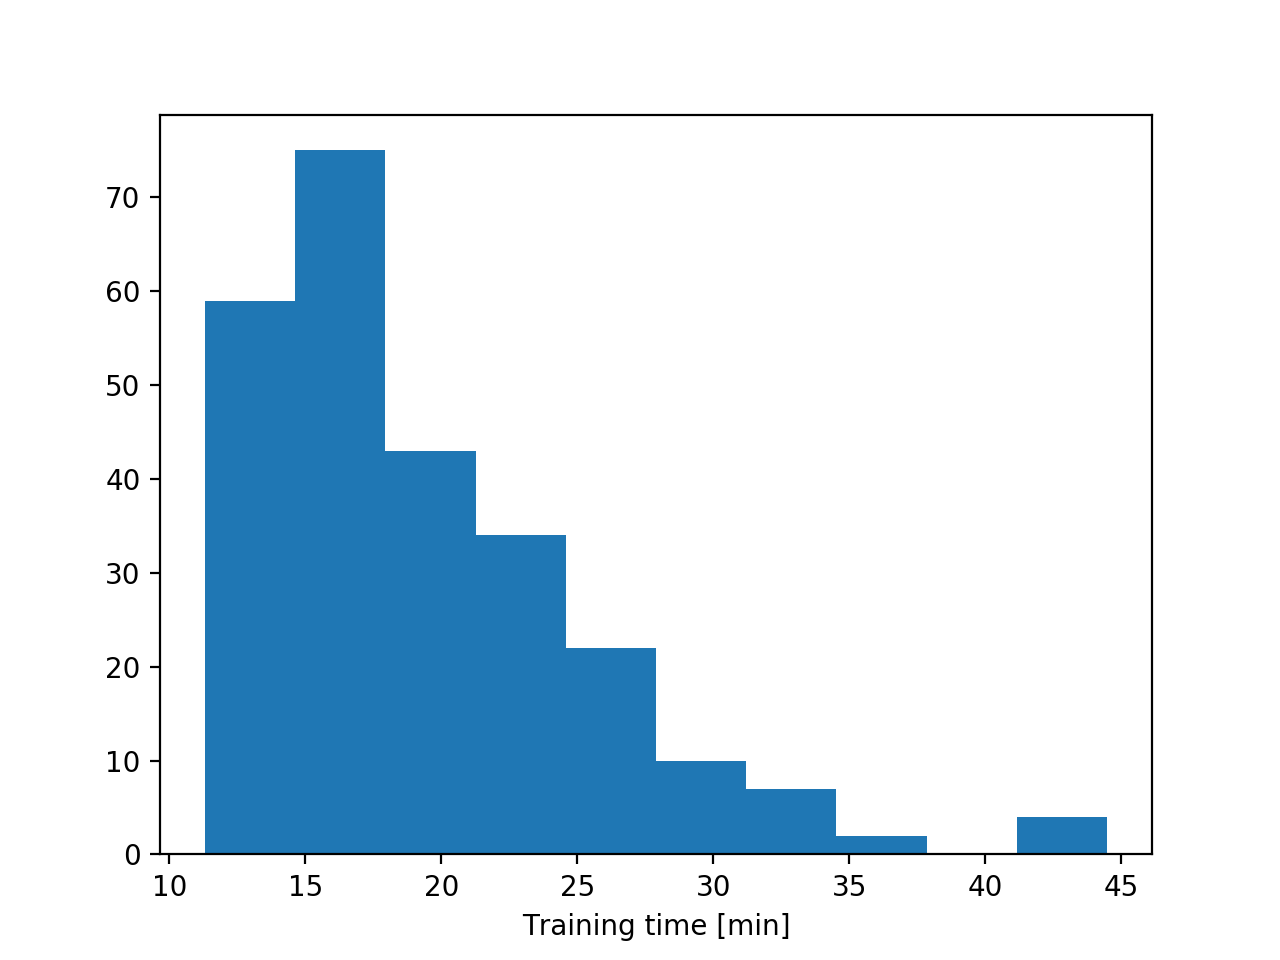

In [97]:
plt.figure()
plt.hist(times)
plt.xlabel('Training time [min]');

## Model selection and evaluation

In [54]:
def draw_history(h):
    plt.figure(figsize=(9,4))
    # Loss
    plt.subplot(121)
    plt.plot(h['loss'], label='Training')
    plt.plot(h['val_loss'], label='Validation')
    plt.xlim(xmin=0, xmax=len(h['loss'])-1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    # Accuracy
    plt.subplot(122)
    plt.plot(h['acc'], label='Training')
    plt.plot(h['val_acc'], label='Validation')
    plt.xlim(xmin=0, xmax=len(h['loss'])-1)
    plt.ylim((0, 1))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.tight_layout()

In [56]:
%matplotlib notebook

In [52]:
last_scores = np.array([h['val_acc'][-1] if h is not None else -1 for h in histories])
best_scores = np.array([max(h['val_acc']) if h is not None else -1 for h in histories])

Hyperparameters: trial 16 conv [ 8  8 64] fc [256] dropout 0.461 opt Nadam, lr 0.001
  Last validation accuracy 0.9895
  Best validation accuracy 0.9895


<IPython.core.display.Javascript object>


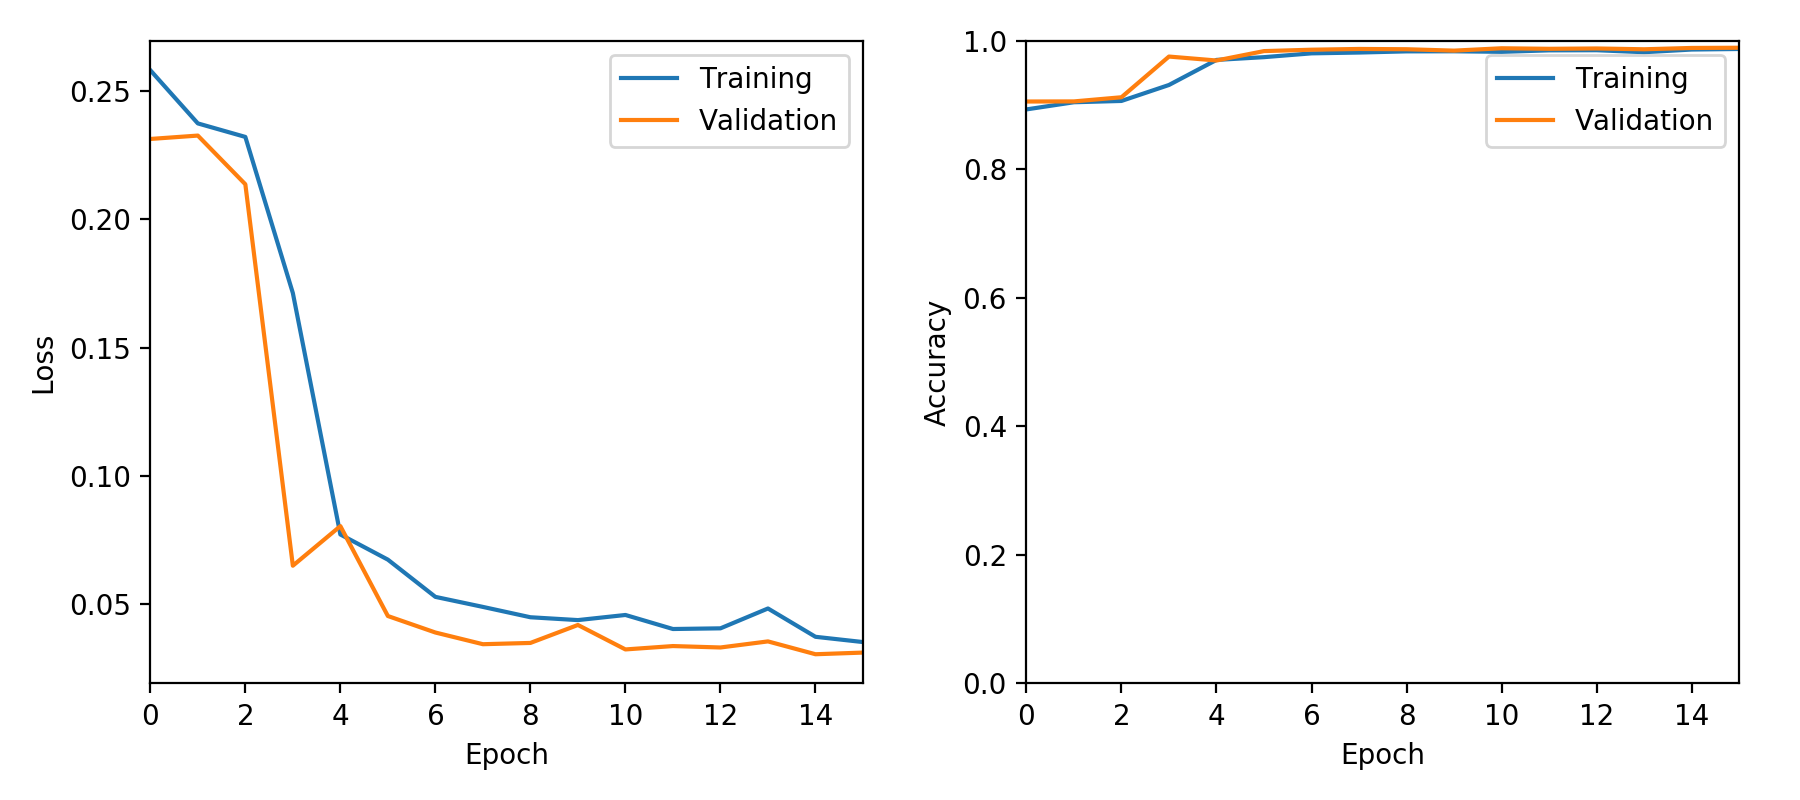

In [57]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmax()
print('Hyperparameters: trial %i conv %s fc %s dropout %.3f opt %s, lr %.3f' %
      (i, conv_sizes[i], fc_sizes[i], dropout[i], optimizer[i], lr[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])
draw_history(histories[i])

Hyperparameters: trial 21 conv [ 4 16  8] fc [256] dropout 0.032 opt Adadelta, lr 0.000
  Last validation accuracy 0.3494
  Best validation accuracy 0.4267


<IPython.core.display.Javascript object>


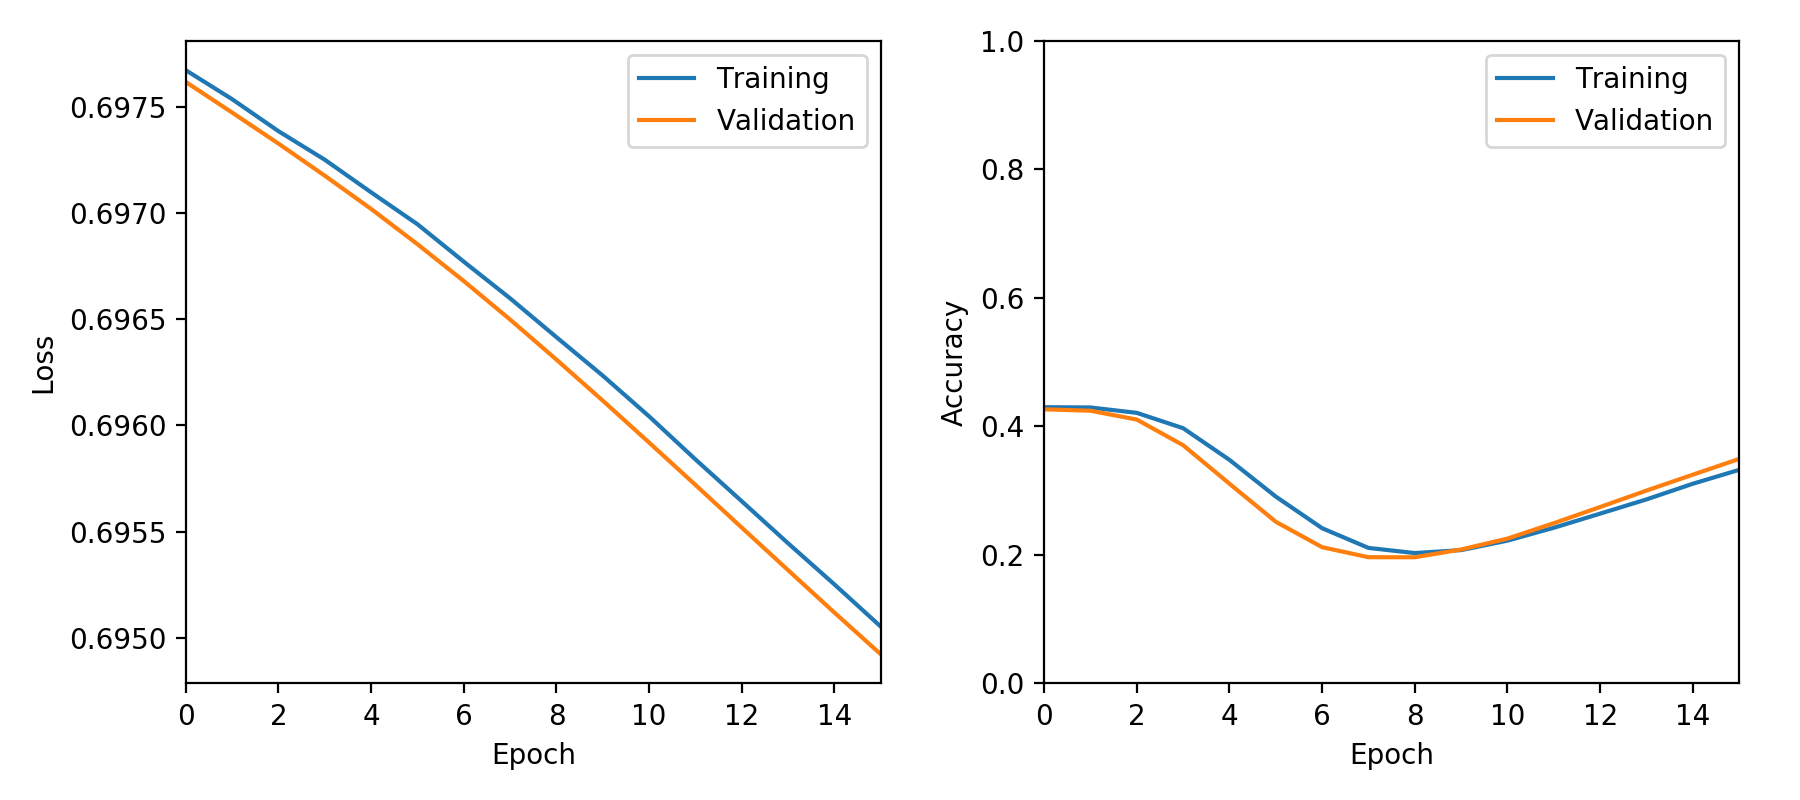

In [69]:
# Find the worst in terms of final validation set accuracy
all_idx = np.arange(len(best_scores))
done_idx = all_idx[best_scores>0]
done_best_scores = best_scores[best_scores>0]
i = done_idx[done_best_scores.argmin()]

print('Hyperparameters: trial %i conv %s fc %s dropout %.3f opt %s, lr %.3f' %
      (i, conv_sizes[i], fc_sizes[i], dropout[i], optimizer[i], lr[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])
draw_history(histories[i])

### Looking for trends in the best hyper-parameter sets

<IPython.core.display.Javascript object>


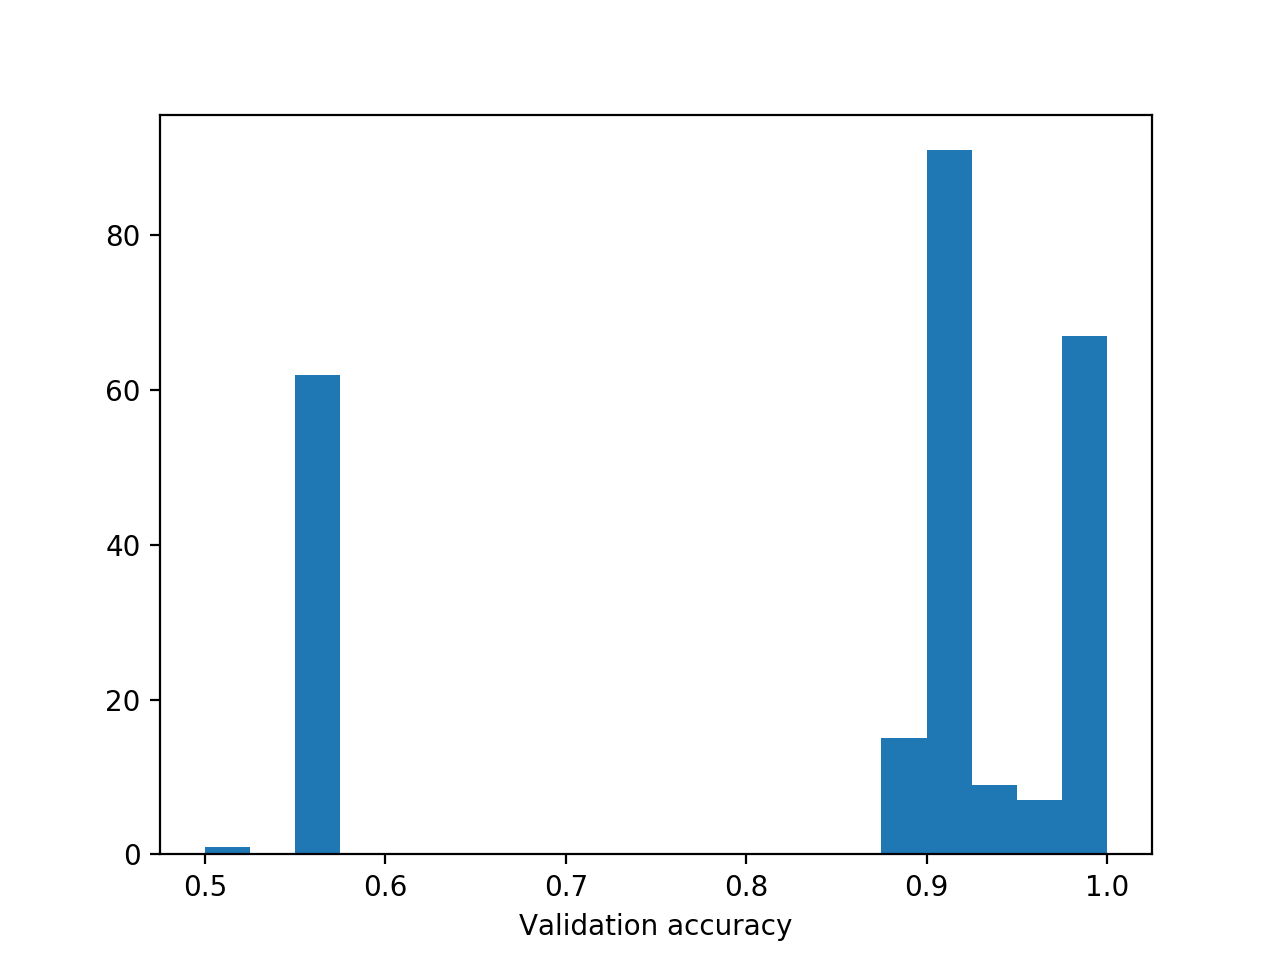

In [70]:
plt.figure()
plt.hist(best_scores, bins=20, range=(0.5, 1))
plt.xlabel('Validation accuracy');

In [71]:
for i in best_scores.argsort()[::-1][:5]:
    print('Hyperparameters: trial %i conv %s fc %s dropout %.3f opt %s, lr %.3f' %
          (i, conv_sizes[i], fc_sizes[i], dropout[i], optimizer[i], lr[i]))
    print('  Best validation accuracy %.4f' % best_scores[i])

Hyperparameters: trial 16 conv [ 8  8 64] fc [256] dropout 0.461 opt Nadam, lr 0.001
  Best validation accuracy 0.9895
Hyperparameters: trial 15 conv [ 8 64 32] fc [128] dropout 0.299 opt Adam, lr 0.001
  Best validation accuracy 0.9890
Hyperparameters: trial 98 conv [16 32 16] fc [256] dropout 0.373 opt Nadam, lr 0.001
  Best validation accuracy 0.9889
Hyperparameters: trial 220 conv [  4  32 128] fc [128] dropout 0.123 opt Nadam, lr 0.001
  Best validation accuracy 0.9888
Hyperparameters: trial 159 conv [ 8  8 32] fc [128] dropout 0.001 opt Adam, lr 0.001
  Best validation accuracy 0.9887


### Test set evaluation

Here we load the best selected model and evaluate final performance on the test set.

In [72]:
from sklearn import metrics

def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    #print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

def draw_roc(labels, outputs, weights=None, ax=None):
    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    auc = metrics.roc_auc_score(labels, outputs, sample_weight=weights)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='CNN, AUC=%.3f' % auc)
    ax.plot([0, 1], [0, 1], '--', label='Random')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc=0)

In [73]:
test_input, test_labels, test_weights = load_file(os.path.join(input_dir, 'test.h5'), n_test)

In [74]:
i = best_scores.argmax()
model_file = os.path.join(checkpoint_dir, 'model_%i.h5' % i)
model = keras.models.load_model(model_file)

In [75]:
test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)

In [76]:
# Unweighted results
print('Unweighted metrics')
summarize_metrics(test_labels, test_output)

# Weighted results
print('Weighted metrics')
summarize_metrics(test_labels, test_output, weights=test_weights)

Unweighted metrics
Accuracy:   0.9883
Purity:     0.9859
Efficiency: 0.9868
Weighted metrics
Accuracy:   0.9762
Purity:     0.0026
Efficiency: 0.9868


<IPython.core.display.Javascript object>


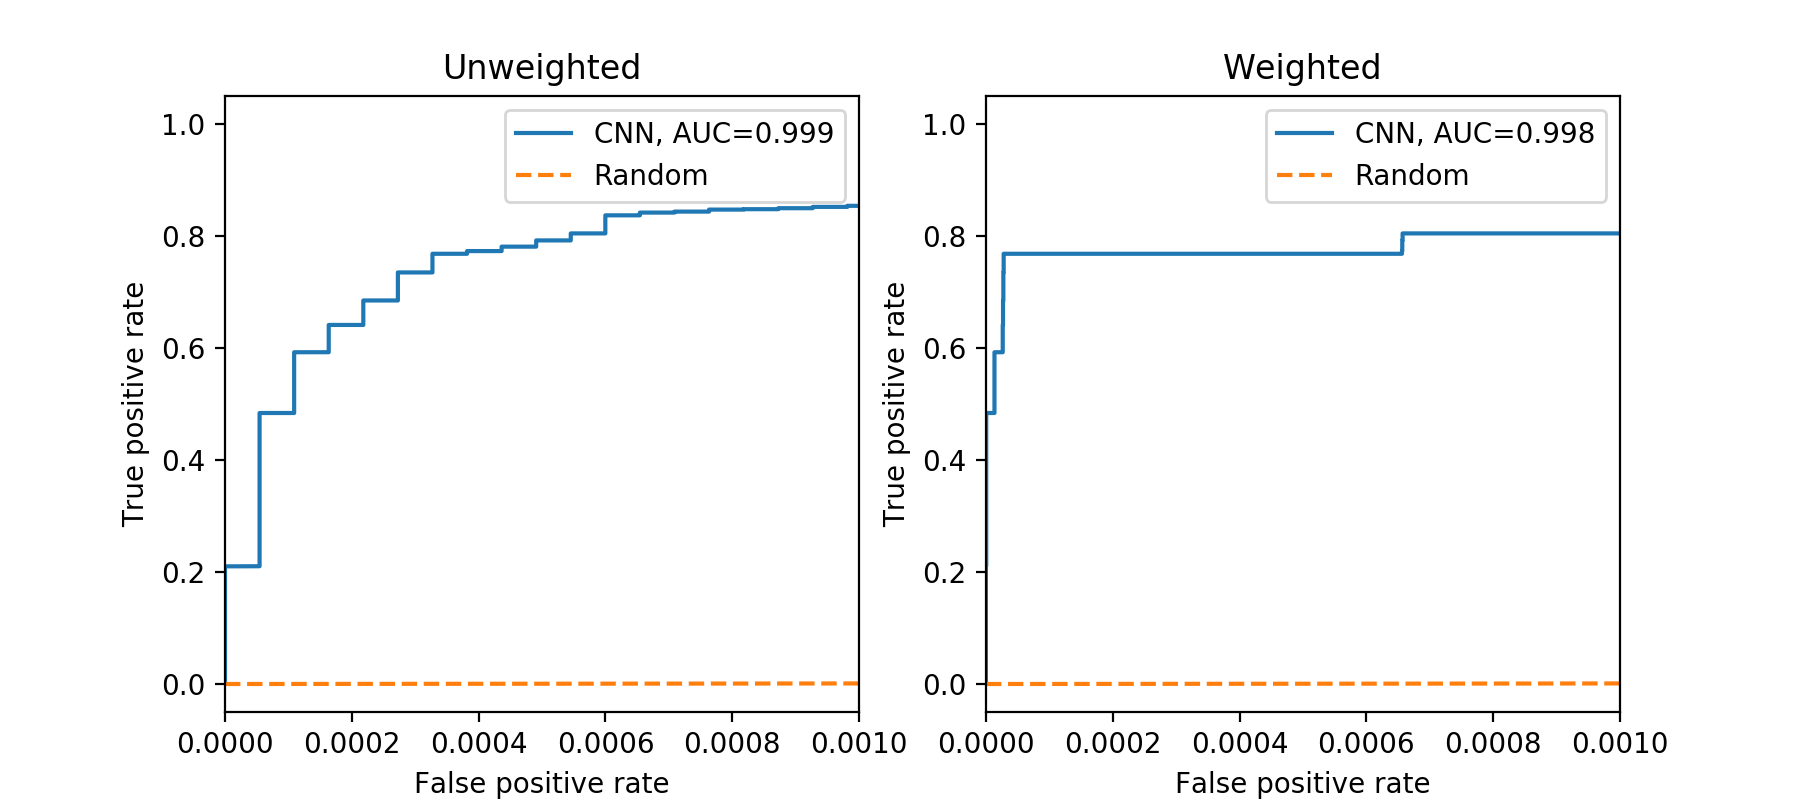

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
draw_roc(test_labels, test_output, ax=axs[0])
draw_roc(test_labels, test_output, ax=axs[1], weights=test_weights)
axs[0].set_xlim([0, 0.001])
axs[0].set_title('Unweighted')
axs[1].set_xlim([0, 0.001])
axs[1].set_title('Weighted');